In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dagger as psc


%matplotlib widget



ny,nx = 256,256
dy,dx = 50,50

Urate = np.zeros((ny,nx)) + 5e-4
Urate[round(2*ny/3):,:] = -1e-6
Urate[:round(1*ny/3),:] = -1e-6
Urate[[-1,0],:] = 0
# Urate[:,[-1,0]] = 0

dt = 200
Kr = 5e-5
Ks = 5e-5
Kle = 0.1
Kld = 0.1

κ_s = 1.5e-2
κ_r = 1e-2

dep =  1
rshp = (ny,nx)

In [2]:
# Initialising an empty model in the variable ts
ts = psc.trackscape()
# Initialising the topography and its dimensions
ts.init_random(nx, ny,dx,dy,"periodic_EW")
# ts.init_perlin(nx, ny,dx,dy,"periodic_EW", 5,8, 10,42, False)

otopo = np.copy(ts.get_topo().reshape(rshp))

# FUnctions to set parameters as global homogeneous values (if not initialised, there is a default value)
ts.set_single_Kr(Kr)
ts.set_single_Ks(Ks)
ts.set_single_depcoeff(dep)

ts.set_dt(dt)
ts.set_fluvial_mode(psc.TSC_FLUVIAL.DAVY2009)
ts.set_fluvial_mode(psc.TSC_FLUVIAL.NONE)
# ts.set_fluvial_mode(psc.TSC_FLUVIAL.FASTSCAPE)
# ts.set_secondary_fluvial_mode(psc.TSC_FLUVIAL.LATERALDAVY)

ts.set_hillslopes_mode(psc.TSC_HILLSLOPE.CIDRE)
ts.set_hillslopes_mode(psc.TSC_HILLSLOPE.HYLANDS)


ts.set_flowtopo_mode(psc.TSC_FLOW_TOPOLOGY.MFD)
# ts.set_flowtopo_mode(psc.TSC_FLOW_TOPOLOGY.SFD)

ts.graph.set_LMR_method(psc.LMR.cordonnier_fill)

ts.set_single_depcoeff(dep)
ts.set_single_Kr(Kr)
ts.set_single_Ks(Ks)

ts.set_single_Kle(Kle)
ts.set_single_Kld(Kld)

ts.set_single_kappa_r(κ_r)
ts.set_single_kappa_s(κ_s)


# Deactivate hilllsopes processes
# ts.hillslopes_off()

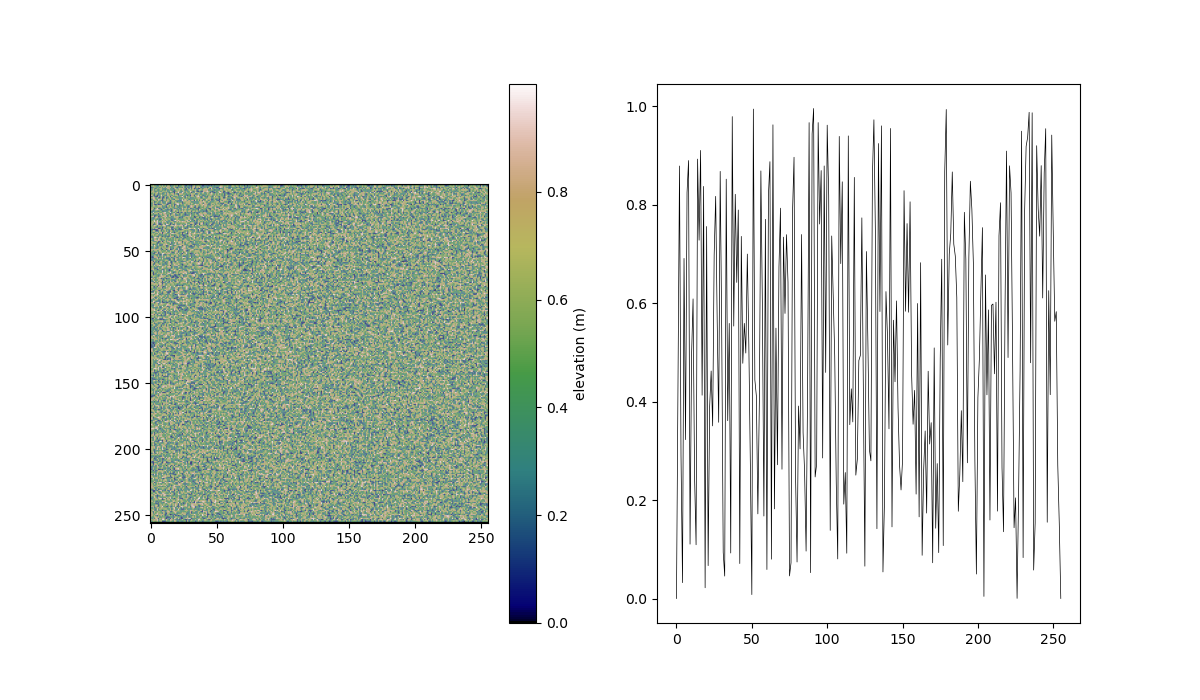

In [3]:
water = False
sediment = False
HS = True


fig,axes = plt.subplots(1,2, figsize = (12,7))
ax,ax1 = axes
topo = ts.get_topo().reshape(rshp)
ths = ts.get_hillshade().reshape(rshp)

# topo = ts.get_Qw().reshape(rshp)
im = ax.imshow(topo, cmap = "gist_earth")
wat = ax.imshow(topo, cmap = "Blues") if water else 0
imsed = ax.imshow(Urate, cmap = "Oranges", alpha = 1) if sediment else 0
imhs = ax.imshow(ths, cmap = "gray", alpha = 0.4, vmin =0, vmax = 1) if HS else 0

proftop = ax1.plot(topo[:, round(nx/2)], lw = 0.5, color = 'k' ) 

plt.colorbar(im, label = "elevation (m)")if(not sediment) else plt.colorbar(imsed, label = "sediment (m)")

In [ ]:
ndt = 100000
nupdate = 100

# Main loop
for i in range(ndt):
    if(i<1000):
        ts.set_dt(dt*0.7)
        ts.set_hillslopes_mode(psc.TSC_HILLSLOPE.CIDRE)
        ts.set_single_Sc(0.7)
    else:
        ts.set_dt(dt*0.5)  
        nupdate = 1
        ts.set_hillslopes_mode(psc.TSC_HILLSLOPE.HYLANDS)

    ts.run()
    # ts.run_SFD(dt)
    ts.external_uplift(Urate, dt, True)
    
    # If nupdate^th timestep: I update the fig
    if(i%nupdate == 0):
        ## printing the timestep
        print("                   ",end = "\r")
        print("Timestep",i,end = "\r")
        
        #GEtting the topography
        topo = ts.get_topo().reshape(rshp)
        twat = np.log10(ts.get_Qw().reshape(rshp)) if water else 0
        ths = ts.get_hillshade().reshape(rshp) if HS else 0
        tsed = ts.get_h_sed().reshape(rshp) if sediment else 0
        # topo = ts.get_Qw().reshape(rshp)
        # Setting the new data
        im.set_data(topo)
        wat.set_data(twat) if water else 0
        imhs.set_data(ths) if HS else 0
        imsed.set_data(tsed) if sediment else 0

        # Setting the new colorbar limits
        im.set_clim(topo.min(), topo.max()) 
        wat.set_clim(twat.min(), twat.max()) if water else 0
        imsed.set_clim(tsed.min(), tsed.max()) if sediment else 0
        
        tprof= np.mean(topo, axis = 1)
        
        proftop[0].set_ydata(tprof)
        ax1.set_ylim(tprof.min(),tprof.max())
        # Apply the update
        fig.canvas.draw()
        
        
        
        

In [ ]:
fig, ax = plt.subplots()

cb = ax.imshow((ts.get_h_sed() - ts.get_topo()).reshape(rshp), vmin = -1, vmax = 1, cmap = "RdBu")
# cb = ax.imshow(otopo - (ts.get_topo()).reshape(rshp))
cb = ax.imshow((ts.get_topo()).reshape(rshp))
# cb = ax.imshow((ts.get_h_sed()).reshape(rshp), alpha = 0)

# cb = ax.imshow(prec.reshape(rshp))
plt.colorbar(cb)

In [5]:
%timeit ts.run()

769 ms ± 7.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit ts.run_SFD_implicit(dt)

6.18 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit ts.run()

6.41 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 0.92, 'Heightmap')

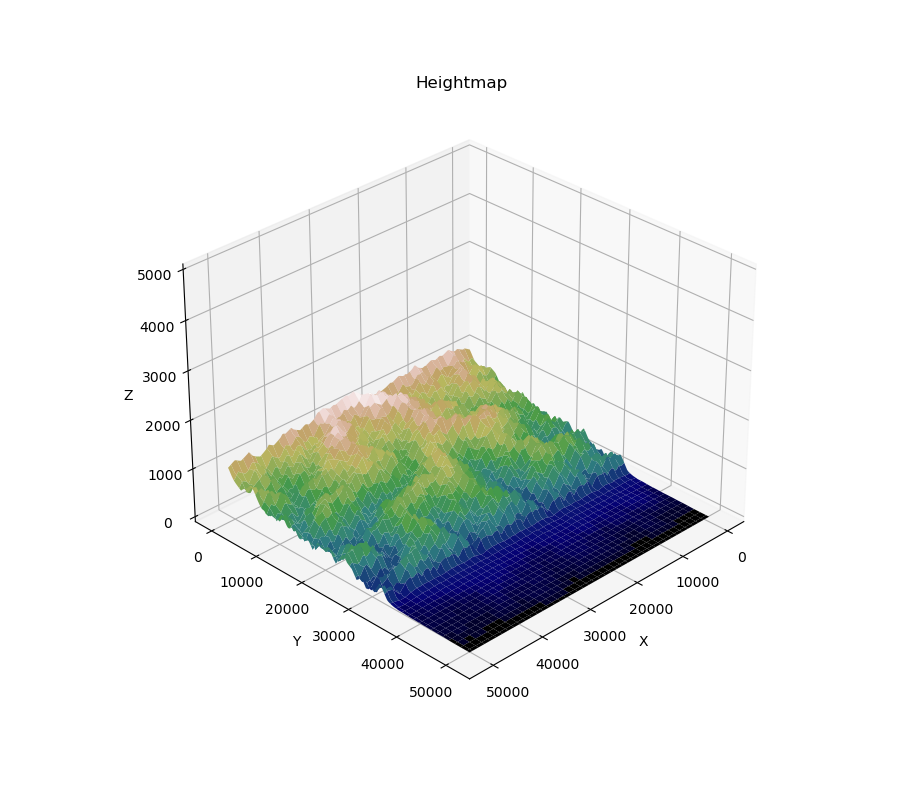

In [99]:

heightmap = ts.get_topo().reshape(ny,nx)

# Create a grid for the x and y coordinates
factor = 200
x, y = np.meshgrid(np.arange(heightmap.shape[1]) * factor, np.arange(heightmap.shape[0]) * factor)

# Plot the heightmap as a 3D surface
fig = plt.figure(figsize = (9,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 750, azim = 45, ro)

ax.plot_surface(x, y, heightmap, cmap = "gist_earth")

ax.set_zlim(0,5000)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Heightmap')
